# Week 3: Using RNNs to predict time series

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.
  
Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import unittests

## Generating the data

Let's begin by defining a bunch of helper functions to generate and plot the time series: 

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

These are the same you have been using in the previous assignments, so you will be generating the same time series data. You can do that with the following function:

In [4]:
def generate_time_series():
    """ Creates timestamps and values of the time series """
    
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

## Defining some useful global variables

Next, you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length od the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**


In [5]:
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series you will use for this assignment. You will save them in the global variables `TIME` and `SERIES`.

In [6]:
# Create the time series
TIME, SERIES = generate_time_series()

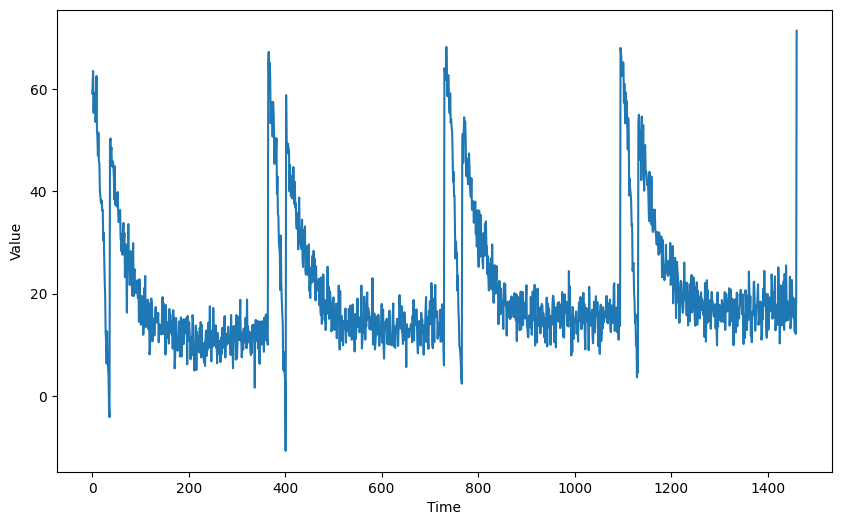

In [7]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you. Notice that in `windowed_dataset` an extra step is added which expands the series to have an extra dimension. This is done because you will be working with RNN-like layers which expect the dimensionality of its inputs to be 3 (including the batch dimension). In the previous weeks you used simple Dense layers which don't have this requirement.


In [8]:
def train_val_split(time, series):
    """ Splits time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [9]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

Now, run the cell below to call these two functions and generate your training dataset:

In [10]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)
# Apply the transformation to the training set
dataset = windowed_dataset(series_train, WINDOW_SIZE)

## Defining the model architecture

### Exercise 1: create_uncompiled_model

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. 

In previous weeks or courses you defined your layers and compiled the model in the same function. However, here you will do thing a little bit different: you will first define the `create_uncompiled_model` function, which only determines your model's structure, and later on you will compile it. This way you can can reuse your model's layers for the learning rate adjusting and the actual training.

Remember that, as you saw on the lectures, there are a couple of layers you will need to add. Firstly, since LSTM and RNN layers expect three dimensions for the input (`batch_size`, `window_size`, `series_dimensionality`), and you have just a univariate time series, you will need to account for this, which can be done via the `tf.keras.Input` (this is already provided for you). Also, it is a good practice to add a layer at the end to make the output values, which are between -1 and 1 for the tanh activation function, be of the same order as the actual values of the series. 

Hint:
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.

- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.
- Fill in the `Lambda` layer at the end of the network with the correct lambda function.

In [11]:
# GRADED FUNCTION: create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """
    ### START CODE HERE ###
    
    model = tf.keras.models.Sequential([ 
        tf.keras.Input((WINDOW_SIZE, 1)), 
		# Your layers go here
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    ### END CODE HERE ###
    
    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**


In [12]:
# Define your uncompiled model
uncompiled_model = create_uncompiled_model()

# Check the parameter count against a reference solution
unittests.parameter_count(uncompiled_model)

Your model has 4,961 total parameters and the reference is 35,000. You are good to go!

Your model has 4,961 trainable parameters and the reference is 35,000. You are good to go!


In [13]:
example_batch = dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

I0000 00:00:1738240753.720121   30048 service.cc:145] XLA service 0x7f79240051b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738240753.720161   30048 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1738240753.918871   30048 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (32, 1)


**Expected output:**

```
Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (NUM_BATCHES, 1)
```
Where `NUM_BATCHES` is the number of batches you have set to your dataset.

In [14]:
# Test your code!
unittests.test_create_uncompiled_model(create_uncompiled_model)

 All tests passed!


As a last check, you can also print a summary of your model to see what the architecture looks like. This can be useful to get a sense of how big your model is.

In [15]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [16]:
def adjust_learning_rate(model):
    """Fit model using different learning rates

    Args:
        model (tf.keras.Model): uncompiled model

    Returns:
        tf.keras.callbacks.History: callback history
    """
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE ###
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE ###
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [17]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(uncompiled_model)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3369.6978 - mae: 46.4838 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 167.6331 - mae: 8.4418 - learning_rate: 1.1220e-06
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.3974 - mae: 4.3014 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.8603 - mae: 4.0346 - learning_rate: 1.4125e-06
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.3859 - mae: 3.6483 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.3113 - mae: 4.4587 - learning_rate: 1.7783e-06
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.7731 - mae: 3.7808 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.0476 - mae: 4.5440 - learning_rate: 2.2387e-06
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.0771 - mae: 4.3982 - learning_rate: 2.5119e-06
Epoch 10/100
3

Plot the achieved loss for each learning rate value, this way you can select an appropriate learning rate for your training.

(1e-06, 1.0, 0.0, 30.0)

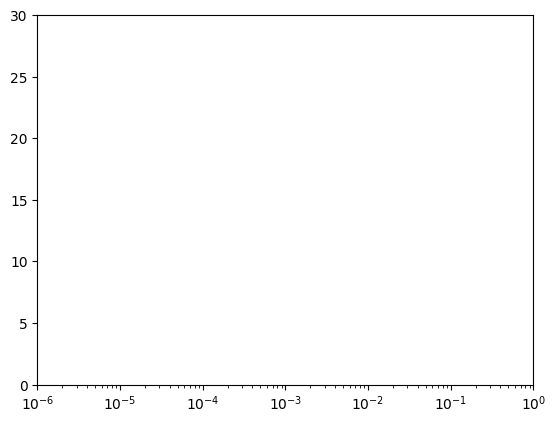

In [18]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

Based on this plot, which learning rate would you choose? You will get to use it on the next exercise.

## Compiling the model

### Exercise 2: create_model

Now it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate). If you completed the previous optional exercise, you should have a pretty good idea of which combinations might work better. 

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [19]:
# GRADED FUNCTION: create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    model = create_uncompiled_model()

    ### START CODE HERE ###
    learning_rate = 1*1e-6

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])  
    
    ### END CODE HERE ###

    return model

In [20]:
# Create an instance of the model
model = create_model()

In [21]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


Now go ahead and train your model:

In [22]:
# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 902.7549 - mae: 24.3538
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.4714 - mae: 5.2008
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.4941 - mae: 3.5493
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.0369 - mae: 4.0394
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7989 - mae: 3.5040
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.0467 - mae: 3.5500
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.9170 - mae: 3.6448
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.8398 - mae: 3.5491
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.4566 - mae: 3.3047
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.3464 - mae: 3.8647
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.5069 - mae: 3.5337
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.6184 - mae: 3.8127
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━

Now go ahead and plot the training loss so you can monitor the learning process.

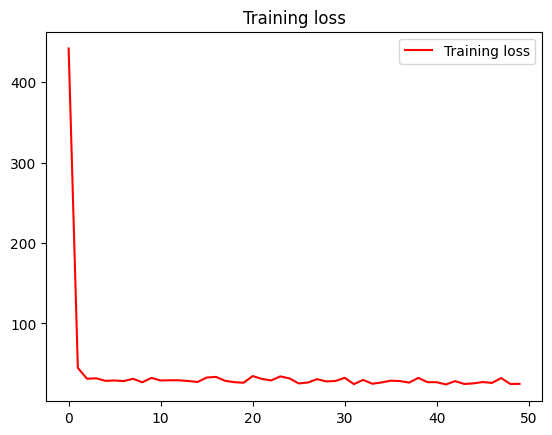

In [23]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [24]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

At this point you have trained the model that will perform the forecast, but you still need to compute the actual forecast. For this, you will use the `generate_forecast` function. This function, which is the same you used on previous assignments, generates the next value given a set of the previous `window_size` points for every point in the validation set. 

In [25]:
def generate_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis])
        forecast.append(pred[0][0])
    return forecast

Now, run the cells below to generate and plot the forecast series:

In [26]:
# Save the forecast
rnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

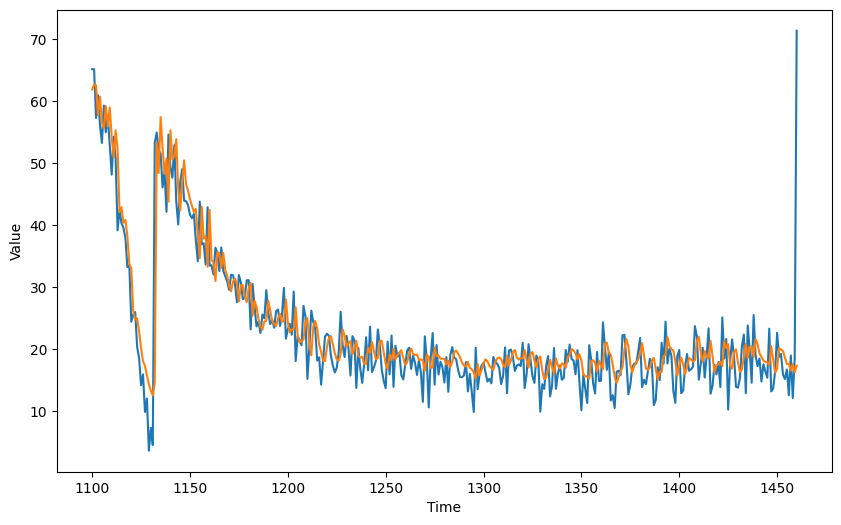

In [27]:
# Plot your forecast
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="650"/>
</div>

Now use the `compute_metrics function` to find the MSE and MAE of your forecast. 

In [28]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.33, mae: 3.44 for forecast


**You will be graded based on your model performance. To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your achieved MAE for the forecast, which will be used for grading. After doing so, submit your assignment for grading.

In [29]:
# Save your mae in a pickle file
with open('forecast_mae.pkl', 'wb') as f:
    pickle.dump(mae.numpy(), f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! **This resulted in a forecast that matches (or even surpasses) the one from last week while training for half of the epochs.**

**Keep it up!**